In [1]:
# EDUFACE - Facial Recognition Attendance System
# Integrated with LMS for student attendance recording
# Date: October 25, 2025

# ================================================
# 1. INSTALLING DEPENDENCIES
# ================================================
# Install required packages
!pip install tensorflow opencv-python matplotlib

# ================================================
# 2. IMPORTING DEPENDENCIES
# ================================================
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# TensorFlow dependencies
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.metrics import Precision, Recall




[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# ================================================
# 3. SET GPU MEMORY GROWTH
# ================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Number of GPUs available:", len(gpus))
else:
    print("No GPUs detected. Running on CPU.")


No GPUs detected. Running on CPU.


In [3]:

# ================================================
# 4. SETTING UP FOLDER STRUCTURE
# ================================================
# Define base paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')

# Create directories
POS_PATH = os.path.join(DATA_PATH, 'positive')
NEG_PATH = os.path.join(DATA_PATH, 'negative')
ANC_PATH = os.path.join(DATA_PATH, 'anchor')

os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

print(f"✅ Directories created/verified:")
print(f"   Positive: {POS_PATH}")
print(f"   Negative: {NEG_PATH}")
print(f"   Anchor: {ANC_PATH}")



✅ Directories created/verified:
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
   Negative: C:\Projects\EDUFACE PROJECT\data\negative
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor


In [22]:
# ================================================
# 5. EXTRACT LFW DATASET FOR NEGATIVES
# ================================================
import tarfile
import glob

# Path to LFW .tgz file
tgz_path = os.path.join(BASE_PATH, 'lfw-funneled.tgz')
extract_path = NEG_PATH

# Validate and extract
if os.path.isfile(tgz_path):
    print(f"Found .tgz file at: {tgz_path}")
    os.makedirs(extract_path, exist_ok=True)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("✅ Dataset extracted successfully!")
    
    # Find LFW root
    possible_roots = [
        os.path.join(extract_path, "lfw_funneled"),
        os.path.join(extract_path, "lfw-funneled"),
        os.path.join(extract_path, "lfw"),
    ]
    lfw_root = next((root for root in possible_roots if os.path.exists(root)), None)
    
    if lfw_root:
        print(f"✅ LFW dataset at: {lfw_root}")
        # Move images to negative folder (flatten structure)
        for person_dir in os.listdir(lfw_root):
            person_path = os.path.join(lfw_root, person_dir)
            if os.path.isdir(person_path):
                for img_file in os.listdir(person_path):
                    src = os.path.join(person_path, img_file)
                    dst = os.path.join(NEG_PATH, img_file)
                    if os.path.exists(dst):
                        os.remove(dst)  # Overwrite duplicates
                    os.rename(src, dst)
        # Clean up empty dirs (note: may need to remove lfw_root if empty)
        print("✅ Negatives moved and structure flattened.")
    else:
        print("⚠️ Could not find LFW root. Check extraction.")
else:
    print("⚠️ LFW .tgz not found. Download from http://vis-www.cs.umass.edu/lfw/")




Found .tgz file at: C:\Projects\EDUFACE PROJECT\lfw-funneled.tgz
✅ Dataset extracted successfully!
✅ LFW dataset at: C:\Projects\EDUFACE PROJECT\data\negative\lfw_funneled
✅ Negatives moved and structure flattened.


In [14]:
# ================================================
# 6. COLLECT POSITIVES AND ANCHORS
# ================================================
# Advanced multi-angle face capture with student info
import time
import uuid
import platform
import glob

def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

# Get student details
student_name = input("Enter student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')

print(f"\n📁 Saving images for {student_name}_{student_id}")
print(f"   Anchor: {ANC_PATH}")
print(f"   Positive: {POS_PATH}")

# Initialize counters
def get_next_count(folder_path, prefix):
    existing = glob.glob(os.path.join(folder_path, f"{prefix}_*.jpg"))
    if existing:
        counts = [int(os.path.basename(f).split('_')[2]) for f in existing if len(os.path.basename(f).split('_')) > 2 and os.path.basename(f).split('_')[2].isdigit()]
        return max(counts) + 1 if counts else 1
    return 1

anchor_count = get_next_count(ANC_PATH, f"{student_name}_{student_id}")
positive_count = get_next_count(POS_PATH, f"{student_name}_{student_id}")

# Load Haar Cascades for multi-angle detection
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}

for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            # Calculate IoU
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                # Keep larger face
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

# Initialize capture
cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found.")

capture_type = "positive"
is_capturing = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        for i, (x,y,w,h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0))
            cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        status = f"Mode: {capture_type.upper()} | Faces: {len(faces)} | {'CAPTURING' if is_capturing else 'PAUSED'}"
        cv2.putText(frame, status, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        count_text = f"Anchor: {anchor_count-1} | Positive: {positive_count-1}"
        cv2.putText(frame, count_text, (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        cv2.imshow("EDUFACE Capture - 'a' anchor, 'p' positive, 'c' hold to capture, 'q' quit", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('a'):
            capture_type = 'anchor'
            print("🔄 ANCHOR mode")
        elif key == ord('p'):
            capture_type = 'positive'
            print("🔄 POSITIVE mode")
        elif key == ord('c'):
            is_capturing = not is_capturing  # Toggle
            print(f"{'Start' if is_capturing else 'Stop'} capturing")
        elif key == ord('q'):
            break

        if is_capturing and faces:
            folder = ANC_PATH if capture_type == 'anchor' else POS_PATH
            count = anchor_count if capture_type == 'anchor' else positive_count
            prefix = f"{student_name}_{student_id}"
            
            for i, (x,y,w,h) in enumerate(faces):
                face_crop = frame[y:y+h, x:x+w]
                ft = face_types[i] if i < len(face_types) else 'frontal'
                angle = ft.replace('frontal','front').replace('_alt','').replace('_alt2','')
                unique_id = str(uuid.uuid4())[:8]
                filename = os.path.join(folder, f"{prefix}_{angle}_{count}_{unique_id}.jpg")
                resized = cv2.resize(face_crop, (250, 250))  # Capture at 250x250
                cv2.imwrite(filename, resized)
                print(f"✅ Saved {os.path.basename(filename)} ({ft}, {capture_type})")
                
                if capture_type == 'anchor':
                    anchor_count += 1
                else:
                    positive_count += 1
            
            time.sleep(0.2)  # Rate limit

finally:
    cap.release()
    cv2.destroyAllWindows()

# Dataset summary
total_anchor = len(glob.glob(os.path.join(ANC_PATH, "*.jpg")))
total_positive = len(glob.glob(os.path.join(POS_PATH, "*.jpg")))
total_negative = len(glob.glob(os.path.join(NEG_PATH, "*.jpg")))

print(f"\n📊 Dataset Summary:")
print(f"   Anchor: {total_anchor}")
print(f"   Positive: {total_positive}")
print(f"   Negative: {total_negative}")

if total_anchor < 10 or total_positive < 10:
    print("⚠️ WARNING: Collect more images (10+ per class) for better performance.")



📁 Saving images for Bahati_Jere_150166
   Anchor: C:\Projects\EDUFACE PROJECT\data\anchor
   Positive: C:\Projects\EDUFACE PROJECT\data\positive
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
Stop capturing
Start capturing
✅ Saved Bahati_Jere_150166_front_1_6cba6e5d.jpg (frontal, positive)
✅ Saved Bahati_Jere_150166_front2_2_f4aef

Raw counts: Anchor=2845, Positive=2673, Negative=13966
Valid students with sufficient data: 802 (['Bahati_Jere_150166_front2_108', 'Bahati_Jere_150166_front2_17', 'Bahati_Jere_150166_front2_21', 'Bahati_Jere_150166_front2_222', 'Bahati_Jere_150166_front2_274', 'Bahati_Jere_150166_front2_27', 'Bahati_Jere_150166_front_136', 'Bahati_Jere_150166_front_15', 'Bahati_Jere_150166_front_273', 'Bahati_Jere_150166_front_301', 'Bahati_Jere_150166_front_61', 'Bahati_Jere_150166_profile_113', 'Bahati_Jere_150166_profile_114', 'Bahati_Jere_150166_profile_115', 'Bahati_Jere_150166_profile_150', 'Bahati_Jere_150166_profile_151', 'Bahati_Jere_150166_profile_152', 'Bahati_Jere_150166_profile_154', 'Bahati_Jere_150166_profile_156', 'Bahati_Jere_150166_profile_165', 'Bahati_Jere_150166_profile_167', 'Bahati_Jere_150166_profile_176', 'Bahati_Jere_150166_profile_180', 'Bahati_Jere_150166_profile_181', 'Bahati_Jere_150166_profile_185', 'Bahati_Jere_150166_profile_195', 'Bahati_Jere_150166_profile_196', 'Baha

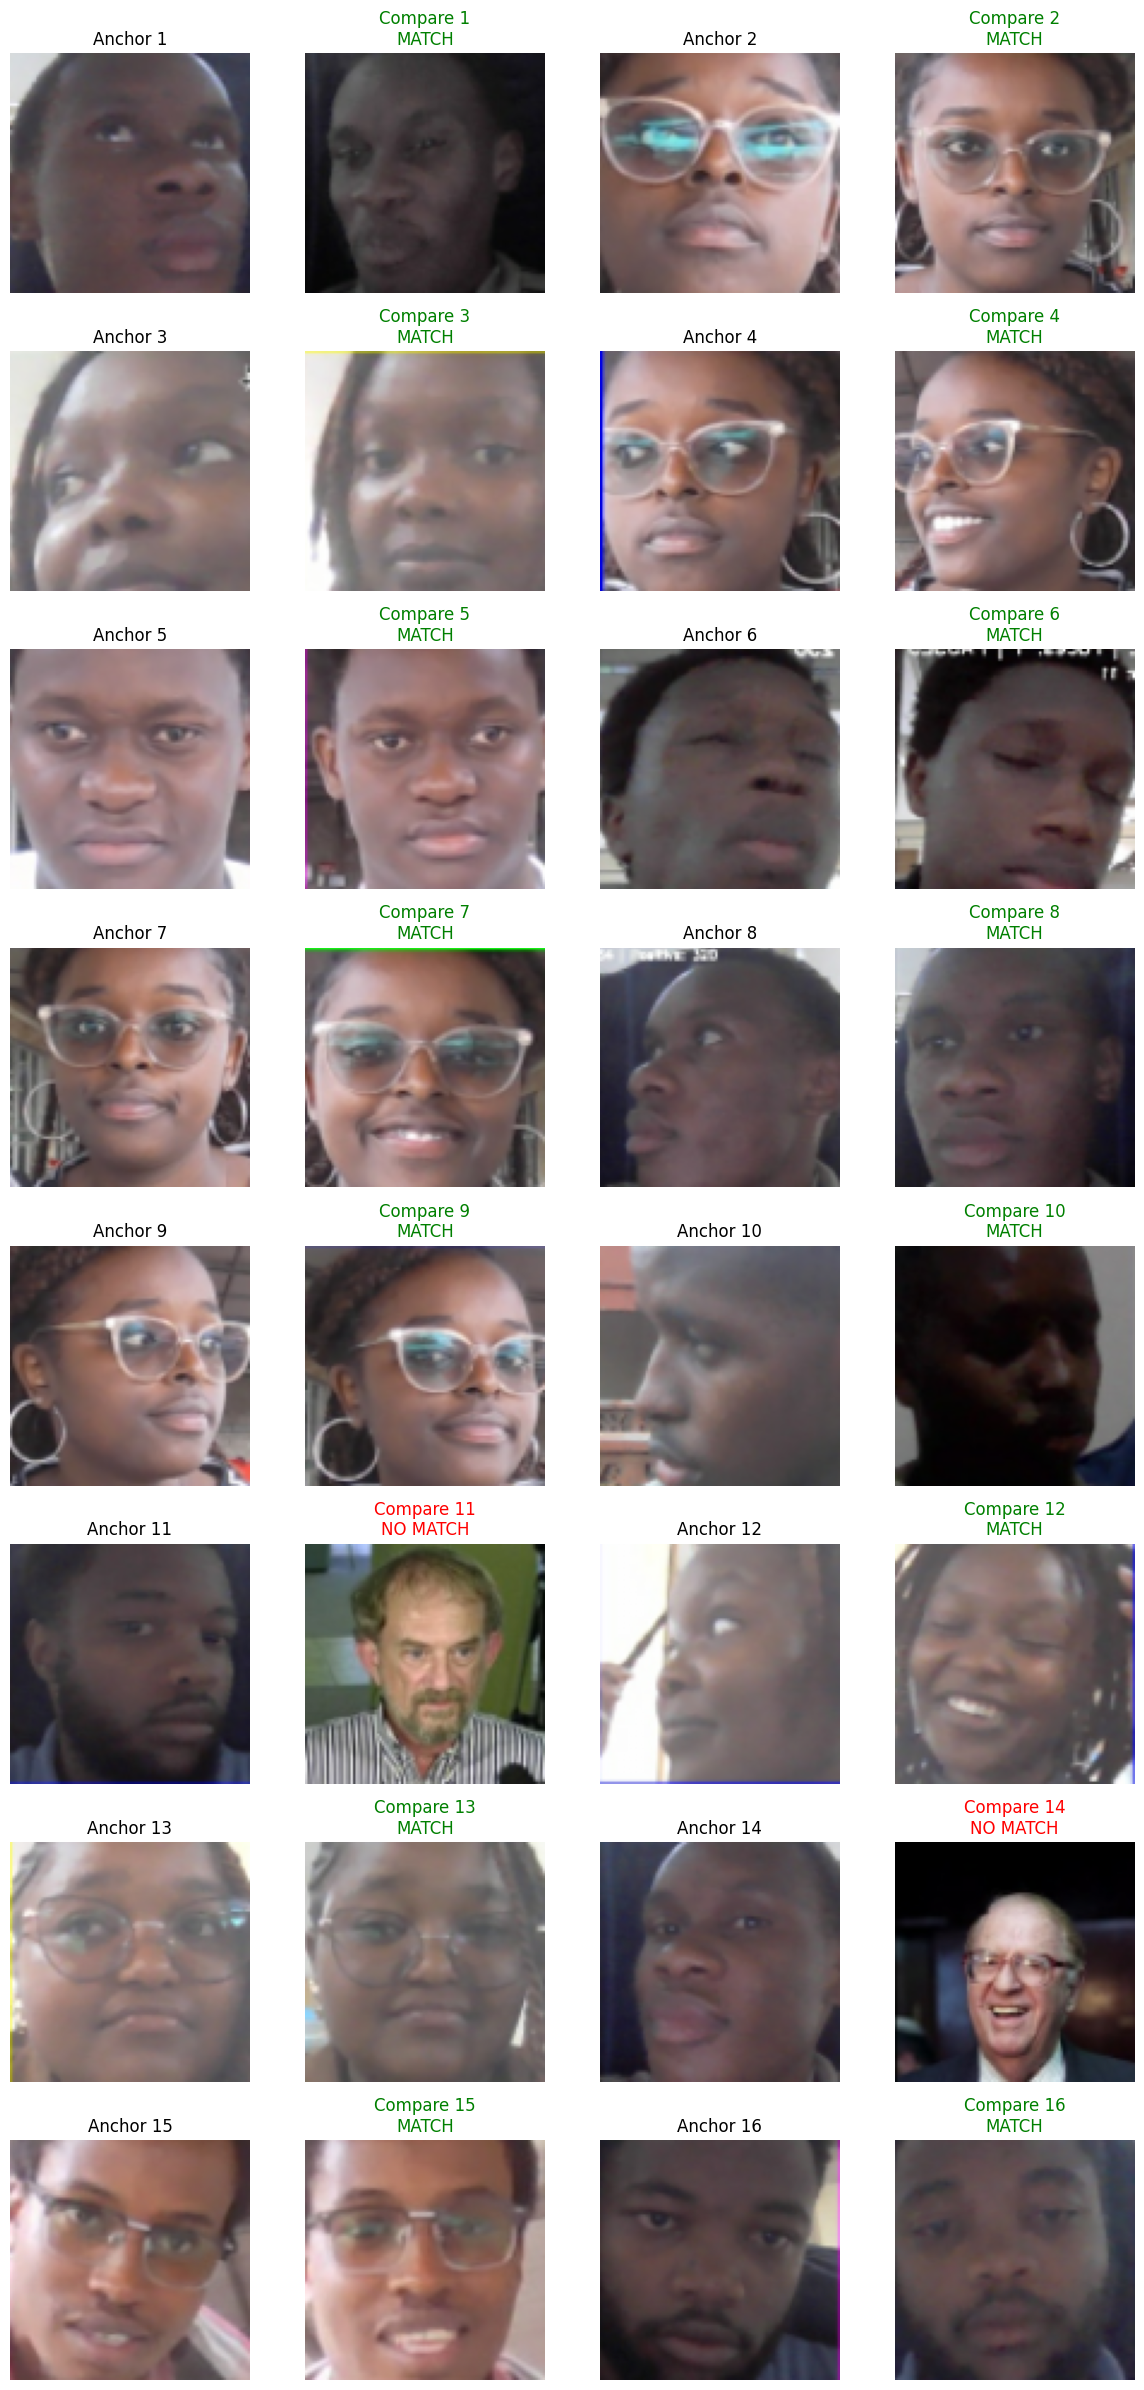

In [15]:
# ================================================
# 7. LOAD AND PREPROCESS IMAGES (FIXED: PER-STUDENT PAIRING)
# ================================================
import glob
import re  # For prefix extraction

# Define preprocess function for single image
def preprocess(file_path):
    # Convert tensor to string if needed (ensures compatibility)
    file_path = tf.strings.as_string(file_path)
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_crop(img, [90, 90, 3])
    img = tf.image.resize(img, (100, 100))  # Resize back to model input size
    img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Define preprocess_twin for pairs
def preprocess_twin(anchor_path, positive_path, label):
    anchor_img = preprocess(anchor_path)
    positive_img = preprocess(positive_path)
    return (anchor_img, positive_img, label)

# Get all image paths (recursive if needed)
all_anchor_files = glob.glob(os.path.join(ANC_PATH, '*.jpg'))
all_positive_files = glob.glob(os.path.join(POS_PATH, '*.jpg'))
all_negative_files = glob.glob(os.path.join(NEG_PATH, '*.jpg'))

print(f"Raw counts: Anchor={len(all_anchor_files)}, Positive={len(all_positive_files)}, Negative={len(all_negative_files)}")

# Extract student prefixes (e.g., 'nellius_123' from filename)
def get_student_prefix(filename):
    basename = os.path.basename(filename)
    # Match pattern: name_id_angle_count_uuid.jpg → extract name_id
    match = re.match(r'([a-zA-Z0-9_]+_[a-zA-Z0-9-]+)_.*\.jpg', basename)
    return match.group(1) if match else 'unknown'

# Group by student
anchor_by_student = {}
positive_by_student = {}
for f in all_anchor_files:
    prefix = get_student_prefix(f)
    if prefix not in anchor_by_student:
        anchor_by_student[prefix] = []
    anchor_by_student[prefix].append(f)

for f in all_positive_files:
    prefix = get_student_prefix(f)
    if prefix not in positive_by_student:
        positive_by_student[prefix] = []
    positive_by_student[prefix].append(f)

# Filter to students with BOTH anchors & positives (min 1 each for demo)
valid_students = [s for s in anchor_by_student if s in positive_by_student and 
                  len(anchor_by_student[s]) >= 1 and len(positive_by_student[s]) >= 1]
print(f"Valid students with sufficient data: {len(valid_students)} ({valid_students})")

# Build paired datasets PER STUDENT (no cross-mixing!)
anchor_paths = []
positive_paths = []
labels = []

for student in valid_students:
    student_anchors = sorted(anchor_by_student[student])  # Sort for consistent pairing
    student_positives = sorted(positive_by_student[student])
    min_per_student = min(len(student_anchors), len(student_positives))
    
    # Pair sequentially: anchor[0] with positive[0], etc. (same session/person)
    for i in range(min_per_student):
        anchor_paths.append(student_anchors[i])
        positive_paths.append(student_positives[i])
        labels.append(1.0)  # True match for this person

# For negatives: Random from ALL (different people), same count as positives
num_pos_pairs = len(anchor_paths)
negative_paths = sorted(all_negative_files)  # Flat LFW
if len(negative_paths) > num_pos_pairs:
    negative_paths = negative_paths[:num_pos_pairs]  # Balance

# Create TF datasets (no shuffle here—pairing is fixed!)
anchor = tf.data.Dataset.from_tensor_slices(anchor_paths)
positive = tf.data.Dataset.from_tensor_slices(positive_paths)
negative = tf.data.Dataset.from_tensor_slices(negative_paths)

# Positives: Zip same-student pairs
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(num_pos_pairs))))

# Negatives: Zip anchors with random negatives (label 0)
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(num_pos_pairs))))

# Combine
data = positives.concatenate(negatives)
print(f"✅ Fixed pairs: {num_pos_pairs} per-student matches + {min(num_pos_pairs, len(negative_paths))} negatives = {tf.data.experimental.cardinality(data).numpy()} total")

# Rest of pipeline (augment AFTER pairing to preserve mappings)
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(1024)  # Shuffle whole dataset now (safe post-pairing)
data = data.batch(16)
data = data.prefetch(8)

print(f"✅ Pipeline ready: {num_pos_pairs * 2} samples, batch size 16")

# Visualize sample batch
try:
    samples = data.as_numpy_iterator()
    batch = next(samples)
    n_samples = batch[0].shape[0]
    if n_samples > 0:
        num_rows = (n_samples + 1) // 2
        fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))
        if num_rows > 1:
            axes = axes.reshape(num_rows, -1)
        else:
            axes = axes.reshape(1, -1)
        for i in range(n_samples):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            axes[row, col1].imshow(batch[0][i])
            axes[row, col1].set_title(f"Anchor {i+1}")
            axes[row, col1].axis('off')
            
            axes[row, col2].imshow(batch[1][i])
            label = "MATCH" if batch[2][i] == 1 else "NO MATCH"
            color = 'green' if batch[2][i] == 1 else 'red'
            axes[row, col2].set_title(f"Compare {i+1}\n{label}", color=color)
            axes[row, col2].axis('off')
        
        # Hide extra subplots if any
        for i in range(n_samples, num_rows * 2):
            row = i // 2
            col1 = (i % 2) * 2
            col2 = col1 + 1
            axes[row, col1].axis('off')
            axes[row, col2].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Empty batch, no visualization.")
except StopIteration:
    print("No data available for visualization.")


In [26]:
# ================================================
# 8. UPDATED SPLIT: 80/10/10 for More Training
# ================================================
total_batches = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.8 * total_batches)  # ~80-81 batches
val_size = int(0.1 * total_batches)    # ~10 batches
test_size = total_batches - train_size - val_size  # ~10 batches

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size)

print(f"Updated Split: Train={train_size} batches (~{train_size*16} samples), Val={val_size} (~{val_size*16}), Test={test_size} (~{test_size*16})")
print(f"Total: {total_batches} batches (~{total_batches*16} samples)")

Updated Split: Train=80 batches (~1280 samples), Val=10 (~160), Test=11 (~176)
Total: 101 batches (~1616 samples)


In [18]:
!pip install scikit-learn


     ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.9 MB 1.3 MB/s eta 0:00:07
     ---------------------------------------- 0.0/8.9 MB 1.3 MB/s eta 0:00:07
     ---------------------------------------- 0.0/8.9 MB 326.8 kB/s eta 0:00:28
     ---------------------------------------- 0.0/8.9 MB 326.8 kB/s eta 0:00:28
     ---------------------------------------- 0.0/8.9 MB 326.8 kB/s eta 0:00:28
     ---------------------------------------- 0.0/8.9 MB 326.8 kB/s eta 0:00:28
     ---------------------------------------- 0.0/8.9 MB 326.8 kB/s eta 0:00:28
     ---------------------------------------- 0.1/8.9 MB 241.3 kB/s eta 0:00:37
     ---------------------------------------- 0.1/8.9 MB 241.3 kB/s eta 0:00:37
     ---------------------------------------- 0.1/8.9 MB 241.3 kB/s eta 0:00:37
     ---------------------------------------- 0.1/8.9 MB 241.3 kB/s eta 0:00:37
     ---------------------------------------- 0.1/8.9


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# ================================================
# BASELINE: Full Test Eval (Add After Step 8)
# ================================================

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Collect all test predictions
test_iterator = test_data.as_numpy_iterator()
test_inputs, test_vals, test_labels = [], [], []

for batch in test_iterator:
    X1, X2, y = batch
    test_inputs.append(X1)
    test_vals.append(X2)
    test_labels.append(y)

# Concatenate
test_inputs = np.concatenate(test_inputs)
test_vals = np.concatenate(test_vals)
test_labels = np.concatenate(test_labels).astype(int)  # Binary labels

# Predict
y_pred_prob = siamese_model.predict([test_inputs, test_vals], verbose=0).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
accuracy = np.mean(y_pred == test_labels)
print(f"Baseline Test Accuracy: {accuracy:.4f}")

# Detailed report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=['No Match', 'Match']))

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
print(f"\nConfusion Matrix:\n{cm}")

# Per-class balance check
num_matches = np.sum(test_labels == 1)
num_non_matches = np.sum(test_labels == 0)
print(f"\nTest Set Balance: Matches={num_matches} ({num_matches/len(test_labels)*100:.1f}%), Non-Matches={num_non_matches}")

Baseline Test Accuracy: 0.6768

Classification Report:
              precision    recall  f1-score   support

    No Match       0.71      0.70      0.71        91
       Match       0.64      0.64      0.64        73

    accuracy                           0.68       164
   macro avg       0.67      0.67      0.67       164
weighted avg       0.68      0.68      0.68       164


Confusion Matrix:
[[64 27]
 [26 47]]

Test Set Balance: Matches=73 (44.5%), Non-Matches=91


In [9]:
# ================================================
# 9. MODEL ENGINEERING
# ================================================
# Build Embedding Model - FIXED: Remove lists from inputs/outputs for single I/O
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=inp, outputs=d1, name='embedding')

embedding = make_embedding()
embedding.summary()

# L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Siamese Model
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()



Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ================================================
# 9.2. FINETUNING PREP: Load, Augment, Freeze & Tune (FINAL FIX FOR BATCHED MAP)
# ================================================
import tensorflow as tf
from tensorflow.keras.layers import Dropout, RandomBrightness, RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import load_model

# Reload custom L1Dist (if not already defined)
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Step 9a: Load Your Saved Model
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')  # From Step 12
siamese_model = load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Loaded saved model for finetuning.")

# Step 9b: Extract Old Embedding for Weight Transfer
embedding = siamese_model.get_layer('embedding')  # Old embedding
print(f"Old embedding layers: {len(embedding.layers)} total.")

# Step 9c: Build Enhanced Embedding with Dropout
def make_enhanced_embedding():
    inp = tf.keras.Input(shape=(100, 100, 3), name='input_image')
    # Existing CNN structure
    c1 = tf.keras.layers.Conv2D(64, (10,10), activation='relu', name='conv1')(inp)
    m1 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool1')(c1)
    c2 = tf.keras.layers.Conv2D(128, (7,7), activation='relu', name='conv2')(m1)
    m2 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool2')(c2)
    c3 = tf.keras.layers.Conv2D(128, (4,4), activation='relu', name='conv3')(m2)
    m3 = tf.keras.layers.MaxPooling2D((2,2), padding='same', name='pool3')(c3)
    c4 = tf.keras.layers.Conv2D(256, (4,4), activation='relu', name='conv4')(m3)
    f1 = tf.keras.layers.Flatten(name='flatten')(c4)
    d1 = tf.keras.layers.Dense(4096, activation='sigmoid', name='dense')(f1)
    d_drop = Dropout(0.3, name='dropout')(d1)  # New: Dropout after Dense
    return tf.keras.Model(inputs=inp, outputs=d_drop, name='embedding_enhanced')

enhanced_embedding = make_enhanced_embedding()

# Transfer weights from old to new (skip dropout)
for old_layer, new_layer in zip(embedding.layers, enhanced_embedding.layers):
    if old_layer.name == new_layer.name and 'dropout' not in new_layer.name:
        try:
            new_layer.set_weights(old_layer.get_weights())
            print(f"Transferred weights for: {old_layer.name}")
        except ValueError as e:
            print(f"⚠️ Skip transfer for {old_layer.name}: {e}")
print("✅ Enhanced embedding with dropout; weights transferred.")

# Step 9c.5: Freeze Early Layers in NEW Embedding
for layer in enhanced_embedding.layers[:4]:  # Input + first 3 blocks
    layer.trainable = False
num_frozen = sum(1 for l in enhanced_embedding.layers if not l.trainable)
print(f"✅ Froze {num_frozen} early layers in enhanced embedding.")

# Step 9d: Rebuild Siamese with Enhanced Embedding
def make_siamese_model(embedding_model):
    input_image = tf.keras.Input(name='input_img', shape=(100,100,3))
    validation_image = tf.keras.Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist(name='distance')
    distances = siamese_layer(embedding_model(input_image), embedding_model(validation_image))
    classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(distances)
    return tf.keras.Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model(enhanced_embedding)
siamese_model.summary()  # Now should show non-trainable params

# Step 9e: Add Augmentation to Train Data (On-the-Fly, FIXED for Batched Tuples)
# Layer-based aug: Brightness/Contrast/Flip/Rotate/Zoom
augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Inferred shape
    RandomRotation(0.1),       # ±5.7° tilt
    RandomZoom(0.1),           # ±10% zoom
    RandomBrightness(0.2),     # ±20% brightness
    RandomContrast(0.2),       # ±20% contrast
], name='augmentation')

# FIXED: Define to take 3 SEPARATE ARGS (TF unpacks batch tuple automatically)
def augment_pairs(anchor, positive, label):
    anchor_aug = augmentation(anchor, training=True)
    positive_aug = augmentation(positive, training=True)
    return (anchor_aug, positive_aug, label)

train_data = train_data.map(augment_pairs, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache().shuffle(1024).prefetch(8)  # No re-batch needed
print("✅ Augmentation added to train_data (val/test unchanged for clean eval).")

# Step 9f: Compile with Lower LR
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)  # Halved for finetuning
siamese_model.compile(optimizer=opt, loss=binary_cross_loss, metrics=['accuracy'])
print(f"✅ Compiled with LR={opt.learning_rate.numpy():.0e}, metrics=accuracy.")

✅ Loaded saved model for finetuning.
Old embedding layers: 10 total.
Transferred weights for: input_image
Transferred weights for: flatten
Transferred weights for: dense
✅ Enhanced embedding with dropout; weights transferred.
✅ Froze 4 early layers in enhanced embedding.


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_enhanced  │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding_enhanc… │
│                     │                   │            │ embedding_enhanc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,543,745 (147.03 MB)

 Non-trainable params: 420,800 (1.61 MB)

✅ Augmentation added to train_data (val/test unchanged for clean eval).
✅ Compiled with LR=5e-05, metrics=accuracy.


In [10]:
# ================================================
# 10. TRAINING SETUP
# ================================================
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

# Checkpoints
checkpoint_dir = os.path.join(BASE_PATH, 'training_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# Train Step
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

# Training Loop with History
def train(data, val_data, EPOCHS):
    history = {'loss': [], 'val_loss': []}
    for epoch in range(1, EPOCHS+1):
        print(f'\n📅 Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss = 0.0
        num_train_batches = 0
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            epoch_loss += loss
            num_train_batches += 1
            progbar.update(idx + 1)
        
        if num_train_batches > 0:
            avg_loss = epoch_loss / num_train_batches
        else:
            avg_loss = 0.0
        history['loss'].append(avg_loss.numpy())
        
        # Validation loss
        val_loss = 0.0
        num_val_batches = 0
        for batch in val_data:
            X = batch[:2]
            y = batch[2]
            yhat = siamese_model(X, training=False)
            val_loss += binary_cross_loss(y, yhat)
            num_val_batches += 1
        if num_val_batches > 0:
            avg_val_loss = val_loss / num_val_batches
        else:
            avg_val_loss = 0.0
        history['val_loss'].append(avg_val_loss.numpy())
        print(f"Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"💾 Checkpoint saved at epoch {epoch}")
    
    return history


🚀 Starting training...

📅 Epoch 1/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step
Loss: 0.3326, Val Loss: 0.1803

📅 Epoch 2/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step
Loss: 0.1876, Val Loss: 0.1109

📅 Epoch 3/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step
Loss: 0.1832, Val Loss: 0.1161

📅 Epoch 4/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step
Loss: 0.1105, Val Loss: 0.0777

📅 Epoch 5/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step
Loss: 0.0753, Val Loss: 0.1564

📅 Epoch 6/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step
Loss: 0.0829, Val Loss: 0.0457

📅 Epoch 7/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step
Loss: 0.0436, Val Loss: 0.0232

📅 Epoch 8/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step
Loss: 0.0686, Val Loss: 0.0316

📅 Epoch 9/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step
Loss: 0.0533, Val Loss: 0.0373

📅 Epoch 10/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step
Loss: 0.0278, Val Loss: 0.0108
💾 Checkpoint saved at epoch 10

📅 Epoch 11/80
58/58 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step
Loss: 0.0101, Val Loss: 0.0051

📅 Epoch 

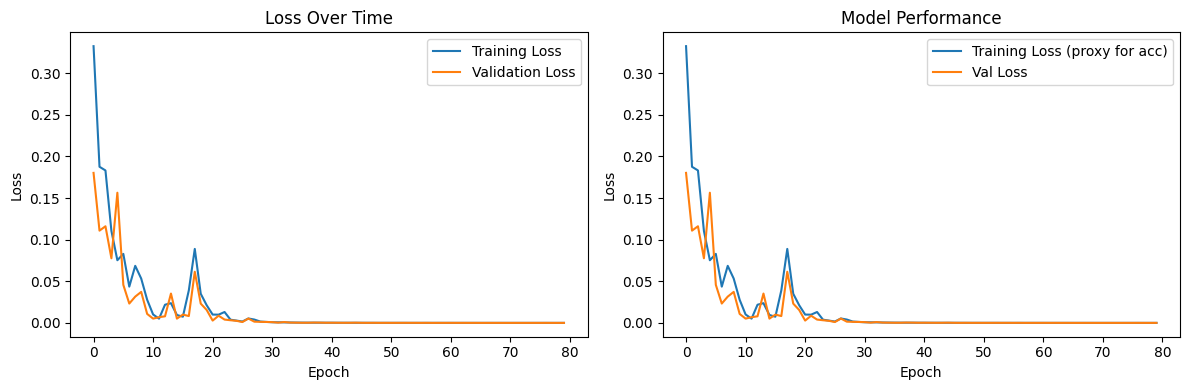

In [11]:

# Train
EPOCHS = 80  # Reduced for demo; increase as needed
print("🚀 Starting training...")
history = train(train_data, val_data, EPOCHS)
print("✅ Training complete!")

# Plot History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')

plt.subplot(1, 2, 2)
# Note: Accuracy not tracked; add if needed
plt.plot(history['loss'], label='Training Loss (proxy for acc)')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')

plt.tight_layout()
plt.show()



In [ ]:
# ================================================
# 10. STABLE ADAPTIVE RETRAIN: No tf.function for Aug Compatibility (80/10/10)
# ================================================
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf  # Assuming TF is imported earlier; add if needed

# Use opt/loss from Step 9f (LR=5e-5)
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)

# Assuming siamese_model, BASE_PATH, train_data, val_data are defined from prior steps
# (e.g., train_data = paired_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE))

# Checkpoint setup
checkpoint_dir = os.path.join(BASE_PATH, 'finetune_checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, 'best_finetuned_siamese.h5')

# FIXED: Python functions (no @tf.function to avoid tracing issues with aug)
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[0]  # (anchor_batch, positive_batch)
        y = batch[1]  # label_batch
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

def val_step(batch):
    X = batch[0]
    y = batch[1]
    yhat = siamese_model(X, training=False)
    return binary_cross_loss(y, yhat)

# Enhanced Loop (same logic)
def adaptive_train(train_data, val_data, max_epochs=50, patience=10, lr_patience=5, lr_factor=0.5, min_lr=1e-7):
    history = {'loss': [], 'val_loss': [], 'lr': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0
    epochs_no_lr_improve = 0
    current_lr = opt.learning_rate.numpy()
    
    # Debug first batch (one-time) - FIXED for nested structure
    first_batch = next(iter(train_data))
    print(f"DEBUG First Batch: Anchor shape={first_batch[0][0].shape}, Positive={first_batch[0][1].shape}, Label={first_batch[1].shape}")
    
    for epoch in range(1, max_epochs + 1):
        print(f'\n📅 Epoch {epoch}/{max_epochs} (LR: {current_lr:.1e})')
        progbar = tf.keras.utils.Progbar(len(train_data))
        
        # Train
        epoch_loss = 0.0
        num_train_batches = 0
        for idx, batch in enumerate(train_data):
            loss = train_step(batch)
            epoch_loss += loss
            num_train_batches += 1
            progbar.update(idx + 1)
        
        avg_train_loss = epoch_loss / num_train_batches if num_train_batches > 0 else 0.0
        history['loss'].append(avg_train_loss.numpy())
        history['lr'].append(current_lr)
        
        # Val
        val_loss = 0.0
        num_val_batches = 0
        for batch in val_data:
            loss = val_step(batch)
            val_loss += loss
            num_val_batches += 1
        avg_val_loss = val_loss / num_val_batches if num_val_batches > 0 else 0.0
        history['val_loss'].append(avg_val_loss.numpy())
        
        print(f"Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early Stop & Save
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            siamese_model.save(best_model_path)
            print(f"💾 Best model saved (val_loss: {best_val_loss:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"🛑 Early stopping after {epoch} epochs")
                break
        
        # LR Decay
        if epoch > 1:
            prev_val_loss = history['val_loss'][-2]
            if avg_val_loss >= prev_val_loss:
                epochs_no_lr_improve += 1
                if epochs_no_lr_improve >= lr_patience:
                    current_lr *= lr_factor
                    if current_lr > min_lr:
                        opt.learning_rate.assign(current_lr)
                        epochs_no_lr_improve = 0
                        print(f"🔄 LR reduced to {current_lr:.1e}")
                    else:
                        print("🛑 Min LR reached; stopping.")
                        break
            else:
                epochs_no_lr_improve = 0
    
    return history

# Run
print("🚀 Starting stable adaptive finetuning...")
history = adaptive_train(train_data, val_data, max_epochs=50)
print("✅ Complete! Best model:", best_model_path)

# Plot
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.twinx()
plt.plot(history['lr'], 'r--', label='LR')
plt.ylabel('Learning Rate')
plt.legend(loc='upper left')
plt.title('Val Loss & LR')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(BASE_PATH, 'stable_finetune_history.png'), dpi=150)
plt.show()

# Summary
best_val_loss = min(history['val_loss'])
best_epoch = history['val_loss'].index(best_val_loss) + 1
print(f"Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch} (Total epochs: {len(history['loss'])})")

🚀 Starting stable adaptive finetuning...
DEBUG First Batch: Anchor shape=(16, 100, 100, 3), Positive=(16, 100, 100, 3), Label=(16,)

📅 Epoch 1/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step


Loss: 0.7455, Val Loss: 0.7049
💾 Best model saved (val_loss: 0.7049)

📅 Epoch 2/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step


Loss: 0.7433, Val Loss: 0.6970
💾 Best model saved (val_loss: 0.6970)

📅 Epoch 3/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step


Loss: 0.7426, Val Loss: 0.6917
💾 Best model saved (val_loss: 0.6917)

📅 Epoch 4/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step
Loss: 0.7348, Val Loss: 0.6953

📅 Epoch 5/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step
Loss: 0.7270, Val Loss: 0.6998

📅 Epoch 6/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step


Loss: 0.7410, Val Loss: 0.6635
💾 Best model saved (val_loss: 0.6635)

📅 Epoch 7/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step
Loss: 0.7374, Val Loss: 0.6853

📅 Epoch 8/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
Loss: 0.7331, Val Loss: 0.6932

📅 Epoch 9/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step


Loss: 0.7240, Val Loss: 0.6269
💾 Best model saved (val_loss: 0.6269)

📅 Epoch 10/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step
Loss: 0.7161, Val Loss: 0.6511

📅 Epoch 11/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step
Loss: 0.7327, Val Loss: 0.6563

📅 Epoch 12/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step
Loss: 0.7458, Val Loss: 0.6757

📅 Epoch 13/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step
Loss: 0.7375, Val Loss: 0.6414

📅 Epoch 14/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step
Loss: 0.7336, Val Loss: 0.7078

📅 Epoch 15/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step
Loss: 0.7241, Val Loss: 0.6496

📅 Epoch 16/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step


Loss: 0.7253, Val Loss: 0.6158
💾 Best model saved (val_loss: 0.6158)

📅 Epoch 17/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step
Loss: 0.7237, Val Loss: 0.6732

📅 Epoch 18/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step
Loss: 0.7396, Val Loss: 0.6724

📅 Epoch 19/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step
Loss: 0.7310, Val Loss: 0.6737

📅 Epoch 20/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step
Loss: 0.7124, Val Loss: 0.7632

📅 Epoch 21/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step
Loss: 0.7299, Val Loss: 0.7984

📅 Epoch 22/50 (LR: 5.0e-05)
80/80 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step
Loss: 0.7294, Val Loss: 0.8199

📅 Epoch 23/50 (LR: 5.0e-05)
37/80 ━━━━━━━━━━━━━━━━━━━━ 1:51 3s/step

In [1]:
# ================================================
# 11. EVALUATE MODEL
# ================================================
# Test on one batch
try:
    test_batch = test_data.as_numpy_iterator().next()
    test_input, test_val, y_true = test_batch
    y_hat = siamese_model.predict([test_input, test_val])

    # Threshold predictions
    res = [1 if pred[0] > 0.5 else 0 for pred in y_hat]

    print(f"Predictions: Matches={sum(res)}/{len(res)}, True matches={int(sum(y_true))}")

    # Metrics
    recall = Recall()
    recall.update_state(y_true, tf.cast(res, tf.float32))
    precision = Precision()
    precision.update_state(y_true, tf.cast(res, tf.float32))

    print(f"\n📊 Metrics on Test Batch:")
    print(f"   Precision: {precision.result().numpy():.4f}")
    print(f"   Recall: {recall.result().numpy():.4f}")

    # Confusion Matrix
    tp = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 1)
    fp = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 1)
    tn = sum(1 for i in range(len(y_true)) if y_true[i] == 0 and res[i] == 0)
    fn = sum(1 for i in range(len(y_true)) if y_true[i] == 1 and res[i] == 0)

    print(f"   TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    accuracy = (tp + tn) / len(y_true)
    print(f"   Accuracy: {accuracy:.4f}")

    # Visualize Predictions
    n_vis = min(8, len(test_input))
    plt.figure(figsize=(15, 5 * ((n_vis + 1) // 2)))
    for i in range(n_vis):
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 1)
        plt.imshow(test_input[i])
        plt.title(f"Anchor {i+1}")
        plt.axis('off')
        
        plt.subplot((n_vis + 1) // 2, 4, 2 * i + 2)
        plt.imshow(test_val[i])
        pred = "MATCH" if res[i] == 1 else "NO MATCH"
        true = "MATCH" if y_true[i] == 1 else "NO MATCH"
        correct = "✅" if res[i] == y_true[i] else "❌"
        color = 'green' if res[i] == y_true[i] else 'red'
        plt.title(f"Compare {i+1}\nPred: {pred}\nTrue: {true} {correct}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
except StopIteration:
    print("No test data available for evaluation.")



NameError: name 'test_data' is not defined

In [13]:
# ================================================
# 12. SAVE MODEL
# ================================================
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
siamese_model.save(model_path)
print(f"✅ Model saved to {model_path}")

✅ Model saved to C:\Projects\EDUFACE PROJECT\siamese_model.h5


In [14]:

# Load test
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Model loaded successfully.")

print("🎉 EDUFACE system ready for LMS integration!")

✅ Model loaded successfully.
🎉 EDUFACE system ready for LMS integration!


In [17]:

# ================================================
# 13. REAL-TIME VERIFICATION (FOR LMS INTEGRATION)
# ================================================
# Create verification images folder if needed
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
os.makedirs(VERIFICATION_PATH, exist_ok=True)
INPUT_PATH = os.path.join(BASE_PATH, 'input_image')
os.makedirs(INPUT_PATH, exist_ok=True)

def preprocess_py(path):
    """Python version of preprocess for non-tensor inputs"""
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = tf.image.random_crop(img, [90, 90, 3])
    img = tf.image.resize(img, (100, 100))  # Resize back to model input size
    img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

def verify(model, detection_threshold=0.5, verification_threshold=0.7):
    verification_images = os.listdir(VERIFICATION_PATH)
    if not verification_images:
        print("No verification images found.")
        return [], False
    
    results = []
    for image in verification_images:
        input_img = preprocess_py(os.path.join(INPUT_PATH, 'input_image.jpg'))
        val_img = preprocess_py(os.path.join(VERIFICATION_PATH, image))
        result = model.predict(np.expand_dims([input_img, val_img], axis=0))[0][0]
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(verification_images)
    verified = verification > verification_threshold
    return results, verified

# Real-time verification
cap = cv2.VideoCapture(0)  # Use default camera
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Crop to face region (adjust as needed)
    frame = frame[120:370, 200:450, :]  # 250x250 crop
    
    cv2.imshow('EDUFACE Verification - Press V to verify, Q to quit', frame)
    
    key = cv2.waitKey(10) & 0xFF
    if key == ord('v'):
        cv2.imwrite(os.path.join(INPUT_PATH, 'input_image.jpg'), frame)
        results, verified = verify(loaded_model)
        status = "VERIFIED ✅" if verified else "NOT VERIFIED ❌"
        confidence = np.mean(results) if results else 0.0
        print(f"{status} (Confidence: {confidence:.2f})")
        # Here: Integrate with LMS - e.g., log attendance for student_id
        print(f"Logging attendance for {student_id}...")
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Training Loss: ['0.3326', '0.1876', '0.1832', '0.1105', '0.0753', '0.0829', '0.0436', '0.0686', '0.0533', '0.0278', '0.0101', '0.0051', '0.0218', '0.0237', '0.0095', '0.0074', '0.0391', '0.0889', '0.0350', '0.0212', '0.0100', '0.0099', '0.0131', '0.0039', '0.0028', '0.0017', '0.0053', '0.0040', '0.0016', '0.0012', '0.0008', '0.0007', '0.0006', '0.0005', '0.0004', '0.0003', '0.0003', '0.0003', '0.0002', '0.0002', '0.0002', '0.0002', '0.0002', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0001', '0.0000', '0.0000', '0.0001', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0000', '0.0

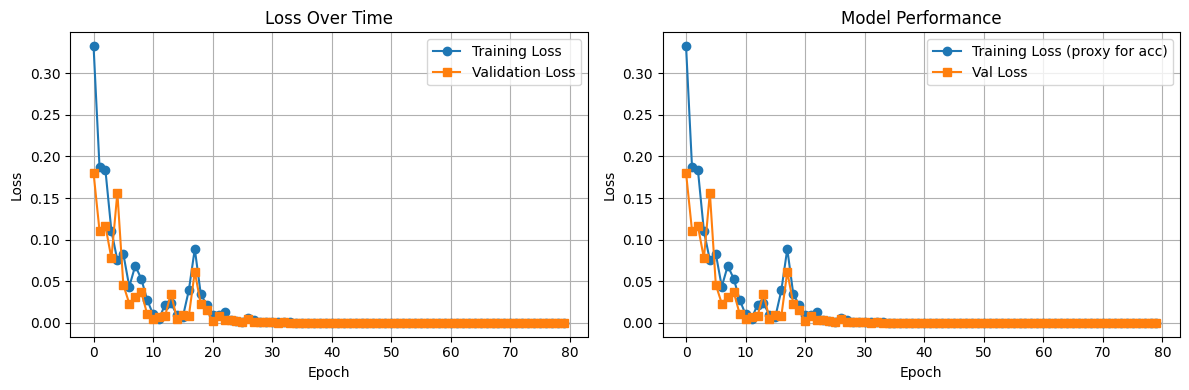


✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!


In [18]:
# Code to extract and print the training history data for the loss plot
# Run this after your training (where 'history' is defined from train() function)

import matplotlib.pyplot as plt
import numpy as np

# Print numerical values (easy to copy-paste)
print("Epochs:", list(range(1, len(history['loss']) + 1)))
print("Training Loss:", [f"{loss:.4f}" for loss in history['loss']])
print("Validation Loss:", [f"{val:.4f}" for val in history['val_loss']])

# Optionally, regenerate and save the plot as PNG (if you have the env)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss (proxy for acc)', marker='o')
plt.plot(history['val_loss'], label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Performance')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_loss_plot.png', dpi=150, bbox_inches='tight')  # Saves to current dir
plt.show()

print("\n✅ Plot saved as 'training_loss_plot.png'. Share the printed values or describe the plot trends!")

In [14]:
# ================================================
# PART 1: STUDENT REGISTRATION/ENROLLMENT - FIXED FILENAME
# ================================================
# Filename now: name_id_count_angle_uuid.jpg (angle after count → clean prefix)

import cv2
import os
import uuid
import time
import platform
import numpy as np
import re  # For prefix extraction

# Setup paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
os.makedirs(VERIFICATION_PATH, exist_ok=True)

# Helper: Get student groups and counts
def get_student_counts(path):
    images = [f for f in os.listdir(path) if f.lower().endswith('.jpg')]
    groups = {}
    messy_files = []  # Flag bad filenames
    for img in images:
        # FIXED: Robust match for new format: name_id_count_angle_uuid
        match = re.match(r'([a-zA-Z0-9_]+_[a-zA-Z0-9-]+)_\d+_[a-z]+_[a-z0-9]+\.jpg', img)
        if match:
            prefix = match.group(1)
            groups.setdefault(prefix, []).append(img)
        else:
            messy_files.append(img)
    counts = {prefix: len(imgs) for prefix, imgs in groups.items()}
    max_count = max(counts.values()) if counts else 0
    return counts, max_count, messy_files

# Pre-scan for balance
counts, max_count, messy = get_student_counts(VERIFICATION_PATH)
if messy:
    print(f"⚠️ Warning: {len(messy)} messy filenames detected. Delete and re-enroll!")
if counts:
    print(f"📊 Current students: {', '.join(f'{k}: {v}' for k, v in counts.items())}")
    suggested = max_count  # Or max_count + 5 for buffer
    print(f"💡 Suggested target: {suggested} (matches max for balance)")
else:
    suggested = 10
    print("💡 No students yet—starting with 10.")

# Get student details (credentials collection)
student_name = input("Enter new student name: ").strip().replace(" ", "_")
student_id = input("Enter school ID: ").strip().replace('<>:"/\\|?*', '_')
target_input = input(f"How many images to capture? (Suggested: {suggested}, Recommended: 15-20, mix front/sides): ") or str(suggested)
target_images = int(target_input)

# Check existing for this student
prefix = f"{student_name}_{student_id}"
existing_count = counts.get(prefix, 0)
to_capture = max(0, target_images - existing_count)
if existing_count > 0:
    print(f"🔄 Re-enrolling {prefix}: {existing_count} existing → capturing {to_capture} more (total {target_images}).")
else:
    print(f"\n📁 Enrolling new {prefix} - Saving to {VERIFICATION_PATH}")
    to_capture = target_images
print("🎥 Tips: Start frontal, then turn head left/right for profiles (sides/chin). Vary lighting/glasses off/on.")

# Find working webcam
def find_working_webcam(max_index=10):
    backends = [None]
    if platform.system() == "Windows":
        backends.extend([cv2.CAP_DSHOW, cv2.CAP_MSMF])
    elif platform.system() == "Linux":
        backends.append(cv2.CAP_V4L2)
    
    for backend in backends:
        for index in range(max_index):
            cap = cv2.VideoCapture(index, backend) if backend else cv2.VideoCapture(index)
            if cap.isOpened():
                ret, _ = cap.read()
                if ret:
                    return cap, index
                cap.release()
    return None, None

cap, index = find_working_webcam()
if cap is None:
    raise ValueError("No webcam found!")

# Load multiple Haar Cascades for full coverage
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}
for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

captured = 0
is_capturing = False
total_target = to_capture  # For display

try:
    while captured < to_capture:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)

        # Draw rectangles if faces detected
        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        num_faces = len(faces)
        for i, (x, y, w, h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0)) if num_faces == 1 else (0,0,255)  # Red if multiple
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        cv2.putText(frame, f"Captured: {captured}/{total_target} (Total goal: {target_images}) | Turn for profiles!", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        status = "CAPTURING (Space to toggle) | Press 'Q' to quit" if is_capturing else "PAUSED - Press Space to start"
        cv2.putText(frame, status, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow(f"EDUFACE Enrollment - {student_name}_{student_id}", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord(' '):  # Space to toggle capture
            is_capturing = not is_capturing
            print(f"{'Started' if is_capturing else 'Stopped'} capturing")
        elif key == ord('q'):
            break

        # Auto-capture if face detected and capturing mode on
        if is_capturing and num_faces == 1 and captured < to_capture:
            (x, y, w, h) = faces[0]
            # Better centered crop
            center_x, center_y = x + w//2, y + h//2
            crop_size = min(w, h) * 1.2  # Slightly larger for context
            half = crop_size // 2
            face_crop = frame[max(0, int(center_y - half)):min(frame.shape[0], int(center_y + half)),
                              max(0, int(center_x - half)):min(frame.shape[1], int(center_x - half))]
            if face_crop.size > 0:  # Ensure not empty
                resized = cv2.resize(face_crop, (250, 250))
            else:
                resized = cv2.resize(frame[y:y+h, x:x+w], (250, 250))
            
            unique_id = str(uuid.uuid4())[:8]
            ft = face_types[0] if len(face_types) > 0 else 'frontal'
            # FIXED: name_id_count_angle_uuid (angle AFTER count)
            filename = f"{student_name}_{student_id}_{existing_count + captured + 1}_{ft}_{unique_id}.jpg"
            filepath = os.path.join(VERIFICATION_PATH, filename)
            cv2.imwrite(filepath, resized)
            print(f"✅ Enrolled image {existing_count + captured + 1}/{target_images}: {filename} (angle: {ft})")
            
            captured += 1
            time.sleep(1)  # Pause for variation

finally:
    cap.release()
    cv2.destroyAllWindows()

# Print credentials summary after enrollment
total_for_student = existing_count + captured
print(f"\n🎉 Enrollment complete for Student: {student_name.replace('_', ' ')} (ID: {student_id})!")
print(f"   📁 Total images saved: {total_for_student} in {VERIFICATION_PATH}")
print("💡 Re-run to verify balance. Now test verification!")

⚠️ Warning: 15 messy filenames detected. Delete and re-enroll!
📊 Current students: michael_151731: 8, ryan_kyalo_151344: 7
💡 Suggested target: 8 (matches max for balance)

📁 Enrolling new Egara_Bahati_150166 - Saving to C:\Projects\EDUFACE PROJECT\verification_images
🎥 Tips: Start frontal, then turn head left/right for profiles (sides/chin). Vary lighting/glasses off/on.
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade
Started capturing
✅ Enrolled image 1/15: Egara_Bahati_150166_1_profile_f4f6b234.jpg (angle: profile)
✅ Enrolled image 2/15: Egara_Bahati_150166_2_frontal_alt_a237a3ea.jpg (angle: frontal_alt)
✅ Enrolled image 3/15: Egara_Bahati_150166_3_profile_4b738323.jpg (angle: profile)
✅ Enrolled image 4/15: Egara_Bahati_150166_4_frontal_alt_b997c416.jpg (angle: frontal_alt)
✅ Enrolled image 5/15: Egara_Bahati_150166_5_frontal_51a7144e.jpg (angle: frontal)
✅ Enrolled image 6/15: Egara_Bahati_150166_6_frontal_alt2_da8880ef.j

In [15]:
# ================================================
# PART 2: DAILY ATTENDANCE VERIFICATION - FIXED GROUPING
# ================================================
# Robust prefix: Takes only name_id, merges any angle-duplicates.

import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer
from datetime import datetime
from PIL import Image  # For any image handling if needed
from collections import defaultdict

# Define custom layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Setup paths
BASE_PATH = r'C:\Projects\EDUFACE PROJECT'
VERIFICATION_PATH = os.path.join(BASE_PATH, 'verification_images')
INPUT_PATH = os.path.join(BASE_PATH, 'input_image')
os.makedirs(INPUT_PATH, exist_ok=True)

# Load model
model_path = os.path.join(BASE_PATH, 'siamese_model.h5')
loaded_model = load_model(model_path, custom_objects={'L1Dist': L1Dist})
print("✅ Model loaded.")

# Updated preprocess (no random for live)
def preprocess_py(path, is_training=False):
    byte_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (100, 100))
    if is_training:
        img = tf.image.random_crop(img, [90, 90, 3])
        img = tf.image.random_flip_left_right(img)
    else:
        # Fixed center crop
        h, w = 100, 100
        crop_h, crop_w = 90, 90
        start_y = (h - crop_h) // 2
        start_x = (w - crop_w) // 2
        img = tf.image.crop_to_bounding_box(img, start_y, start_x, crop_h, crop_w)
    img = tf.image.resize(img, (100, 100))
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

# FIXED: Robust prefix extractor - only name_id, ignore angle/count/uuid
def get_student_prefix(filename):
    basename = os.path.splitext(filename)[0]  # Remove .jpg
    # Split once after name_id (before _count_angle_uuid)
    parts = basename.split('_', 2)  # Max 2 splits
    if len(parts) >= 2:
        return '_'.join(parts[:2])  # e.g., pambie_150166
    return 'unknown'

# UPDATED: Split prefix into name and ID
def split_credentials(prefix):
    if prefix == 'unknown' or '_' not in prefix:
        return None, None
    name, id_ = prefix.rsplit('_', 1)  # Split once from right
    return name.replace('_', ' '), id_  # Restore spaces

# UPDATED: Merge duplicate groups (e.g., if old _frontal lingers)
def merge_student_groups(all_images):
    groups = defaultdict(list)
    for image in all_images:
        prefix = get_student_prefix(image)
        if prefix != 'unknown':
            groups[prefix].append(image)
    return dict(groups)  # Clean dict

# Test the fix
print("🧪 Testing prefix extraction and credential split on sample files:")
sample_files = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')][:5]
for f in sample_files:
    prefix = get_student_prefix(f)
    name, sid = split_credentials(prefix)
    print(f"  {f} → Prefix: {prefix} → Name: '{name}', ID: {sid}")

# Simulate merge
all_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
merged_groups = merge_student_groups(all_images)
print(f"\n✅ Merged groups: {len(merged_groups)} unique students - {list(merged_groups.keys())}")

# Load Haar Cascades (unchanged)
cascades = {}
cascade_files = {
    'frontal': 'haarcascade_frontalface_default.xml',
    'profile': 'haarcascade_profileface.xml',
    'frontal_alt': 'haarcascade_frontalface_alt.xml',
    'frontal_alt2': 'haarcascade_frontalface_alt2.xml'
}
for name, file in cascade_files.items():
    cascade_path = cv2.data.haarcascades + file
    cascade = cv2.CascadeClassifier(cascade_path)
    if not cascade.empty():
        cascades[name] = cascade
        print(f"✅ Loaded {name} cascade")

def detect_faces_multi(gray):
    all_faces = []
    types = []
    for name, cascade in cascades.items():
        scale = 1.1 if 'profile' in name else 1.3
        neighbors = 4 if 'profile' in name else 5
        faces = cascade.detectMultiScale(gray, scaleFactor=scale, minNeighbors=neighbors, minSize=(30, 30))
        for face in faces:
            all_faces.append(face)
            types.append(name)
    return all_faces, types

def remove_overlaps(faces, types, threshold=0.3):
    if len(faces) <= 1:
        return faces, types
    keep = [True] * len(faces)
    for i in range(len(faces)):
        if not keep[i]: continue
        for j in range(i+1, len(faces)):
            if not keep[j]: continue
            x1, y1, w1, h1 = faces[i]
            x2, y2, w2, h2 = faces[j]
            inter_x = max(0, min(x1+w1, x2+w2) - max(x1, x2))
            inter_y = max(0, min(y1+h1, y2+h2) - max(y1, y2))
            inter = inter_x * inter_y
            union = w1*h1 + w2*h2 - inter
            iou = inter / union if union > 0 else 0
            if iou > threshold:
                if w1*h1 >= w2*h2:
                    keep[j] = False
                else:
                    keep[i] = False
                    break
    return [faces[i] for i in range(len(faces)) if keep[i]], [types[i] for i in range(len(types)) if keep[i]]

# Updated verify - FIXED GROUPING + PREDICT
def verify(model, detection_threshold=0.6, verification_threshold=0.7):
    verification_images = [f for f in os.listdir(VERIFICATION_PATH) if f.lower().endswith('.jpg')]
    if not verification_images:
        print("⚠️ No enrolled images found!")
        return None, None, None, [], False
    
    input_img_path = os.path.join(INPUT_PATH, 'input_image.jpg')
    if not os.path.exists(input_img_path):
        return None, None, None, [], False
    
    input_img = preprocess_py(input_img_path, is_training=False)
    
    # FIXED: Merge groups first
    student_groups = merge_student_groups(verification_images)
    print(f"DEBUG: Merged students ({len(student_groups)} groups): {list(student_groups.keys())}")
    
    if not student_groups:
        print("⚠️ No valid student groups found!")
        return None, None, None, [], False
    
    # Compute scores
    student_scores = {}
    all_results = []
    for student_prefix, images in student_groups.items():
        print(f"\nDEBUG: Processing {student_prefix} ({len(images)} images)...")
        results = []
        for image in images:
            val_img_path = os.path.join(VERIFICATION_PATH, image)
            val_img = preprocess_py(val_img_path, is_training=False)
            
            # FIXED: Correct batching
            batched_input = np.expand_dims(input_img, axis=0)
            batched_val = np.expand_dims(val_img, axis=0)
            result = model.predict([batched_input, batched_val], verbose=0)[0][0]
            print(f"  Debug: {image} score: {result:.3f}")
            
            results.append(result)
            all_results.append(result)
        if results:
            avg_score = np.median(results)
            student_scores[student_prefix] = avg_score
            print(f"  → {student_prefix}: median score {avg_score:.3f}")
    
    if not student_scores:
        return None, None, None, [], False
    
    # Find best
    best_prefix = max(student_scores, key=student_scores.get)
    best_score = student_scores[best_prefix]
    print(f"\nDEBUG: Best prefix: {best_prefix} ({best_score:.3f})")
    
    # Split to get name and ID
    best_name, best_id = split_credentials(best_prefix)
    
    verified = best_score > verification_threshold
    if verified and best_name and best_id:
        print(f"🔍 Mapped to Student: {best_name} (ID: {best_id}) (Confidence: {best_score:.2f})")
        return best_prefix, best_name, best_id, all_results, verified
    else:
        print(f"❌ No strong match. Closest: {best_name or best_prefix} ({best_score:.2f}) — Re-enroll with more variety?")
        return None, None, None, all_results, False

# Live loop (unchanged, but now with fixed verify)
print("🔍 Class Session Mode: Scan face → Get Student Name & ID + Log Attendance.")

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise ValueError("No webcam.")

print("🎥 Clear face. Green=detected. 'V' to scan (1 face only), 'Q' quit.")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces, face_types = detect_faces_multi(gray)
        faces, face_types = remove_overlaps(faces, face_types)
        
        # Draw
        colors = {'frontal': (0,255,0), 'profile': (255,0,0), 'frontal_alt': (0,255,255), 'frontal_alt2': (255,0,255)}
        num_faces = len(faces)
        for i, (x,y,w,h) in enumerate(faces):
            ft = face_types[i] if i < len(face_types) else 'frontal'
            color = colors.get(ft, (0,255,0)) if num_faces == 1 else (0,0,255)
            cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
            cv2.putText(frame, ft.replace('_',' ').title(), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        status = f"Class Scan | Faces: {num_faces} | 'V' to verify attendance"
        cv2.putText(frame, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imshow('EDUFACE Class Attendance', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('v'):
            if num_faces == 1:
                (x, y, w, h) = faces[0]
                # Centered crop
                center_x, center_y = x + w//2, y + h//2
                crop_size = min(w, h) * 1.2
                half = crop_size // 2
                face_crop = frame[max(0, int(center_y - half)):min(frame.shape[0], int(center_y + half)),
                                  max(0, int(center_x - half)):min(frame.shape[1], int(center_x + half))]
                if face_crop.size > 0:
                    resized_crop = cv2.resize(face_crop, (250, 250))
                else:
                    resized_crop = cv2.resize(frame[y:y+h, x:x+w], (250, 250))
                cv2.imwrite(os.path.join(INPUT_PATH, 'input_image.jpg'), resized_crop)
                print("📸 Face scanned.")
                
                best_prefix, best_name, best_id, results, verified = verify(loaded_model)
                if best_prefix and verified and results and best_name and best_id:
                    avg_conf = np.mean([s for s in results if s > 0.6])
                    status = "PRESENT ✅"
                    print(f"{status} - Student: {best_name} (ID: {best_id}) (Conf: {avg_conf:.2f})")
                    
                    # Log with name and ID
                    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    log_entry = f"{best_name},{best_id},{status},{avg_conf:.2f},{timestamp}"
                    log_file = os.path.join(BASE_PATH, 'class_attendance.csv')
                    with open(log_file, 'a', encoding='utf-8') as f:
                        if os.path.getsize(log_file) == 0 if os.path.exists(log_file) else True:
                            f.write("StudentName,StudentID,Status,Confidence,Timestamp\n")
                        f.write(log_entry + '\n')
                    print(f"📝 Logged to: {log_file}")
                else:
                    print("⚠️ No match—check lighting/angles or re-enroll student?")
            else:
                print(f"⚠️ Need exactly 1 face ({num_faces} detected).")
        elif key == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()

print("🎉 Class session complete! Check 'class_attendance.csv' for name/ID logs.")

✅ Model loaded.
🧪 Testing prefix extraction and credential split on sample files:
  Egara_Bahati_150166_10_profile_78397460.jpg → Prefix: Egara_Bahati → Name: 'Egara', ID: Bahati
  Egara_Bahati_150166_11_frontal_alt2_6dc07f09.jpg → Prefix: Egara_Bahati → Name: 'Egara', ID: Bahati
  Egara_Bahati_150166_12_frontal_alt2_3850233e.jpg → Prefix: Egara_Bahati → Name: 'Egara', ID: Bahati
  Egara_Bahati_150166_13_frontal_alt2_0c8c2627.jpg → Prefix: Egara_Bahati → Name: 'Egara', ID: Bahati
  Egara_Bahati_150166_14_frontal_3ce51cb3.jpg → Prefix: Egara_Bahati → Name: 'Egara', ID: Bahati

✅ Merged groups: 3 unique students - ['Egara_Bahati', 'michael_151731', 'ryan_kyalo']
✅ Loaded frontal cascade
✅ Loaded profile cascade
✅ Loaded frontal_alt cascade
✅ Loaded frontal_alt2 cascade
🔍 Class Session Mode: Scan face → Get Student Name & ID + Log Attendance.
🎥 Clear face. Green=detected. 'V' to scan (1 face only), 'Q' quit.
📸 Face scanned.
DEBUG: Merged students (3 groups): ['Egara_Bahati', 'michael_1517